In [430]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from os import stat
import pylab
import scipy.stats as stats
from scipy.stats import shapiro, median_test, chi2_contingency
from statsmodels.tsa.stattools import adfuller
from imblearn.over_sampling import SMOTENC
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from lightgbm import LGBMClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
import datetime as dt

### Extracting Data

In [3]:
df = pd.read_csv("data_test(2).csv")

#### Notas Generales 

1. Existen 1200 filas y 7 columnas.
2. Campos ID enteros: PayerId, ReceiverId, InvoicedId.
3. Campos Objectos: paidAt, status.
4. Campos Flotantes: amount, amountfinancedByXepelin.
5. PaidAt tiene el 25% de campos faltantes de los cuales corresponden a transacciones PROCESSING y FAILED.
6. Del 25% anterior el 100% de datos pertenecen a PROCESSING y a FAILED.
7. Montos pagados y financiados parecen tener consistencia, sin embargo, hay un valor que es muy alto al resto. ¿Podría considerarse un Outlier?
8. El campo "amount" no sigue una ley normal, por lo que la relación con el pago fallado se busca hacerlo con la prueba de la igualdad de la mediana

#### Preguntas.

1. ¿Porque fallan los pagos?
  * ¿Existe alguna relación con los Payers o Receivers?
  * ¿Existe alguna relación con los montos?
  * Si existe una relación de pagos fallidos con los usuarios, ¿entonces los pagos en PROCESSING podrán ser también fallidos?
2. ¿Puede pronosticarse un pago en PROCESSING como PAID?
3. ¿Se observa temporalidad en los pagos gloables?
4. ¿Se observa temporalidad en los pagos financiados globales?

  

#### Structure Analysis

In [14]:
# Shape of dataframe
df.shape

(1200, 7)

In [167]:
df["NormalizedAmount"] = (df["amount"]-df["amount"].min())/(df["amount"]-df["amount"].min()).max()
df["NormalizedAmountFinancedByXepelin"] = (df["amountfinancedByXepelin"]-df["amountfinancedByXepelin"].min())/(df["amountfinancedByXepelin"]-df["amountfinancedByXepelin"].min()).max()

In [168]:
# Structure Information
structure_information = pd.DataFrame({
    "datatypes":pd.value_counts(df.dtypes).keys().tolist(),
    "frequency":pd.value_counts(df.dtypes).values.tolist(),
    "columns":[df.select_dtypes(include=key).columns.tolist() for key in pd.value_counts(df.dtypes).keys()]
})
structure_information["datatypes"] = structure_information["datatypes"].astype(str)
structure_information

,datatypes,frequency,columns
0,float64,4,"[amount, amountfinancedByXepelin, NormalizedAm..."
1,int64,3,"[PayerId, ReceiverId, invoiceId]"
2,datetime64[ns],1,[paidAt]
3,object,1,[status]


### Missing Value Analysis

In [169]:
df.isnull().sum()

PayerId                                0
ReceiverId                             0
invoiceId                              0
paidAt                               308
amount                                 0
amountfinancedByXepelin                0
status                                 0
NormalizedAmount                       0
NormalizedAmountFinancedByXepelin      0
dtype: int64

### Describing Numerical Variables

In [170]:
df[["amount","amountfinancedByXepelin"]].describe()

,amount,amountfinancedByXepelin
count,1.200000e+03,1.200000e+03
mean,2.785217e+04,1.749303e+04
std,1.414899e+05,1.229016e+05
min,5.816000e+01,0.000000e+00
25%,1.251810e+03,0.000000e+00
50%,1.490460e+03,0.000000e+00
75%,4.120858e+03,0.000000e+00
max,3.370742e+06,3.370742e+06


### Brief date paidAt field analysis

In [48]:
paid_at_missing = df[df["paidAt"].isnull()]["status"].value_counts().to_dict()
status_dict = df["status"].value_counts().to_dict()

for key in status_dict:
  if key in paid_at_missing.keys():
    paid_at_missing[key] = paid_at_missing[key]/status_dict[key]

print(f"PaidAt Missing Values %: {round(df['paidAt'].isnull().sum()/len(df['paidAt']), 2) }")
print(f"PaidAt Missing Values % by Status Categories: {paid_at_missing}")

PaidAt Missing Values %: 0.26
PaidAt Missing Values % by Status Categories: {'PROCESSING': 1.0, 'FAILED': 1.0}


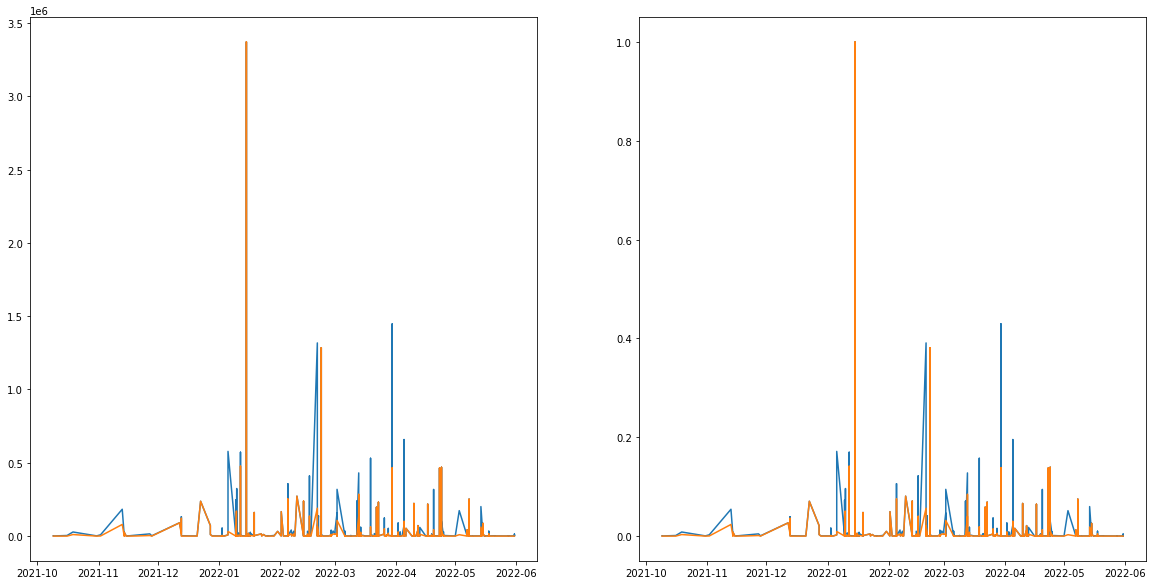

In [164]:
df["paidAt"] = pd.to_datetime(df["paidAt"])

fig, axes = plt.subplots(1,2, figsize=(20,10))

df_sorted = df.loc[df["status"].isin(["PAID"])].sort_values(by="paidAt") 

axes[0].plot(df_sorted["paidAt"], df_sorted["amount"])
axes[0].plot(df_sorted["paidAt"], df_sorted["amountfinancedByXepelin"])
axes[1].plot(df_sorted["paidAt"], df_sorted["NormalizedAmount"])
axes[1].plot(df_sorted["paidAt"], df_sorted["NormalizedAmountFinancedByXepelin"])

In [432]:
df["paidAt_monthly"] = pd.to_datetime(df["paidAt"], format="%Y-%m")
df["paidAt_monthly"] = df.loc[df["status"].isin(["PAID"])]["paidAt_monthly"].apply(lambda x: dt.datetime.strftime(x, "%Y-%m"))
df_ts_amount = df.groupby(["paidAt_monthly"])["NormalizedAmount"].sum()

adf, p, usedlag, nobs, critical_values, icbest = adfuller(df_ts_amount)

if p < 0.05:
  print("Los datos cuentan con estacionalidad.")
  print(f"P-Value: {p}")
else: 
  print("Los datos NO cuentan con estacionalidad.")
  print(f"P-Value: {p}")

Los datos NO cuentan con estacionalidad.
P-Value: 0.12949654819684286


In [433]:
df["paidAt_monthly"] = pd.to_datetime(df["paidAt"], format="%Y-%m")
df["paidAt_monthly"] = df.loc[df["status"].isin(["PAID"])]["paidAt_monthly"].apply(lambda x: dt.datetime.strftime(x, "%Y-%m"))
df_ts_amount = df.groupby(["paidAt_monthly"])["NormalizedAmountFinancedByXepelin"].sum()

adf, p, usedlag, nobs, critical_values, icbest = adfuller(df_ts_amount)

if p < 0.05:
  print("Los datos cuentan con estacionalidad.")
  print(f"P-Value: {p}")
else: 
  print("Los datos NO cuentan con estacionalidad.")
  print(f"P-Value: {p}")

Los datos NO cuentan con estacionalidad.
P-Value: 0.17041018580432815


### Global Visualization Analysis

<Figure size 2880x720 with 0 Axes>

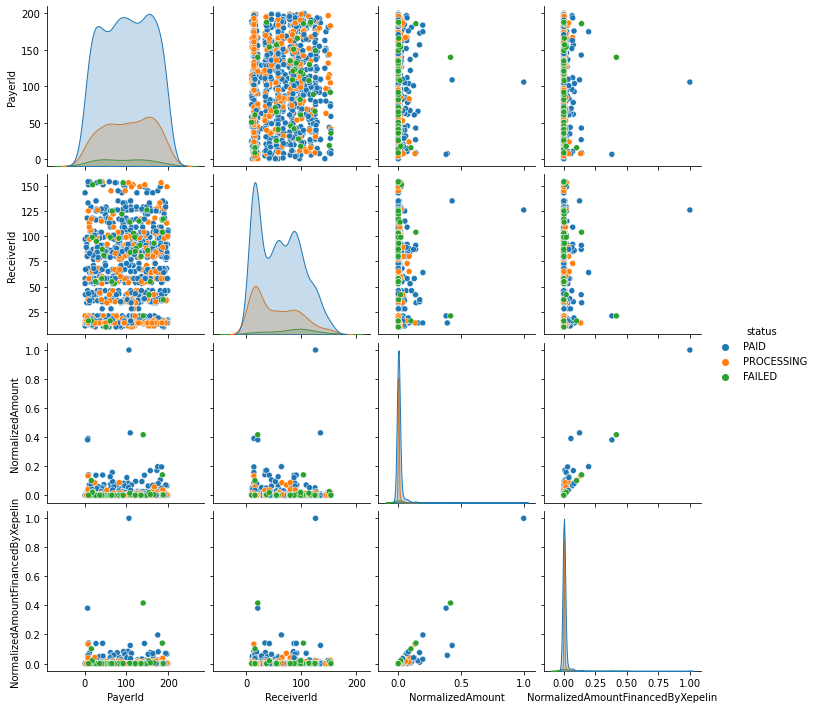

In [374]:
plt.figure(figsize=(40,10))
sns.pairplot(df[["PayerId","ReceiverId","NormalizedAmount","NormalizedAmountFinancedByXepelin","status"]], hue="status")
plt.show()

### Outliers Visualization Test Confirmation

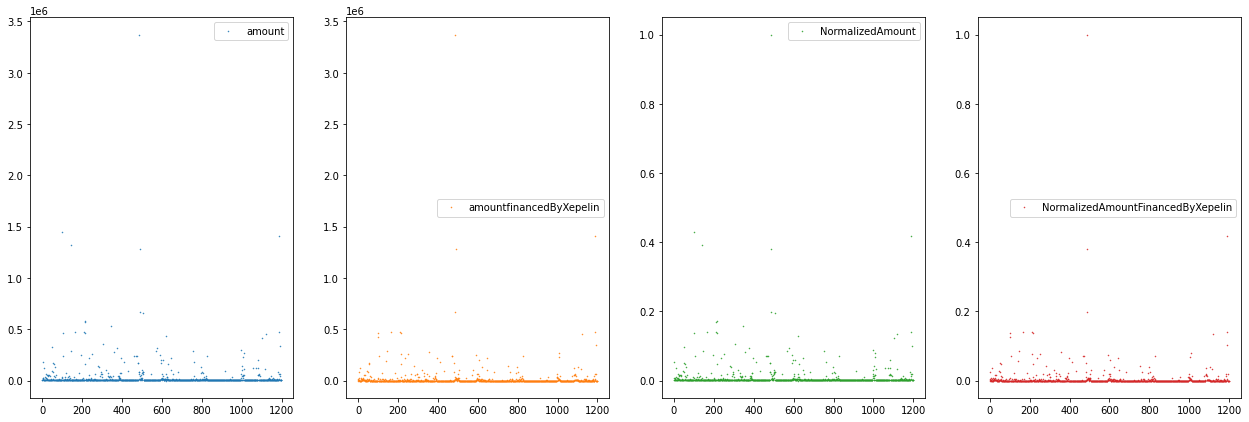

In [176]:
numerical_columns = structure_information.loc[structure_information["datatypes"].isin(["float64"])]["columns"].values.tolist()[0]
df[numerical_columns].plot(lw=0, marker=".", subplots=True, layout=(-1, 9), figsize=(50, 7), markersize=1)
plt.show()

### Normality Test on Amount Field

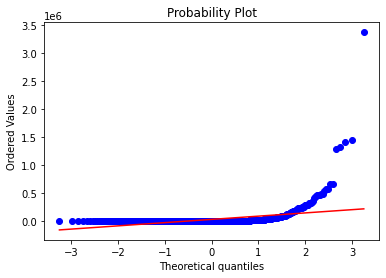

In [112]:
## Q-Q Graphic 
stats.probplot(df["amount"], dist="norm", plot=pylab)
pylab.show()

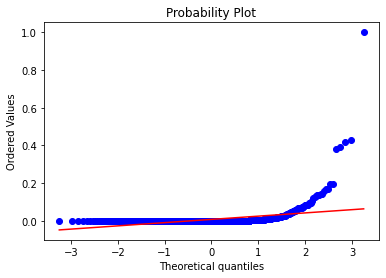

In [177]:
## Q-Q Graphic 
stats.probplot(df["NormalizedAmount"], dist="norm", plot=pylab)
pylab.show()

In [382]:
df

,PayerId,ReceiverId,invoiceId,paidAt,amount,amountfinancedByXepelin,status,NormalizedAmount,NormalizedAmountFinancedByXepelin,paidAt_monthly,status_numerical
0,53,10,18660729,2022-04-23,1490.46,0.00,PAID,0.000425,0.000000,2022-04-23,1
1,93,11,18660730,2021-11-20,6418.28,624.48,PAID,0.001887,0.000185,2021-11-20,1
2,122,12,18660731,2021-10-19,27979.20,10520.15,PAID,0.008283,0.003121,2021-10-19,1
3,85,13,18660732,2021-11-13,183070.77,79421.63,PAID,0.054295,0.023562,2021-11-13,1
4,87,14,18660733,2022-03-23,20532.00,20532.00,PAID,0.006074,0.006091,2022-03-23,1
...,...,...,...,...,...,...,...,...,...,...,...
1195,9,16,18661924,NaT,1281.86,0.00,FAILED,0.000363,0.000000,NaT,-1
1196,135,80,18661925,NaT,1147.86,0.00,FAILED,0.000323,0.000000,NaT,-1
1197,61,16,18661926,NaT,1490.46,0.00,FAILED,0.000425,0.000000,NaT,-1
1198,36,154,18661927,NaT,800.66,0.00,FAILED,0.000220,0.000000,NaT,-1


In [117]:
## Shapiro Wilk Test
test, p = shapiro(df["amount"])

if p < 0.05:
  print("Los datos tienen una distrubución No Normal o Asimétrica.")
  print(f"Test: {test} - P-Value: {p}")
else: 
  print("Los datos tienen una distribución Normal.")
  print(f"Test: {test} - P-Value: {p}")

Los datos tienen una distrubución No Normal o Asimétrica.
Test: 0.17064636945724487 - P-Value: 0.0


In [178]:
## Shapiro Wilk Test
test, p = shapiro(df["NormalizedAmount"])

if p < 0.05:
  print("Los datos tienen una distrubución No Normal o Asimétrica.")
  print(f"Test: {test} - P-Value: {p}")
else: 
  print("Los datos tienen una distribución Normal.")
  print(f"Test: {test} - P-Value: {p}")

Los datos tienen una distrubución No Normal o Asimétrica.
Test: 0.17064636945724487 - P-Value: 0.0


#### ¿Existe una relación entre los estados de la variable status y el amount?

In [375]:
## Dado que salario tiene una distribución asimétrica. No se puede evaluar la relación entre la variable status y amount usando la igualdad de medias o prueba T. Por lo que buscamos la igualdad de medianas
## buscando finalmente descartar H0. 

stat, p, med, tbl = median_test(df.loc[df["status"].isin(["PROCESSING"])]["amount"], df.loc[df["status"].isin(["FAILED"])]["amount"], df.loc[df["status"].isin(["PAID"])]["amount"])
if p < 0.05:
  print(f"Las variables amount y status si guardan una relación por lo que el status del pago puede depender del monto a pagar. - {p}")
else: 
  print("Las variables amount y status no guardan una relación por lo que el status del pago no depende del monto a pagar.")

Las variables amount y status si guardan una relación por lo que el status del pago puede depender del monto a pagar. - 0.047748885720609105


In [179]:
## Dado que salario tiene una distribución asimétrica. No se puede evaluar la relación entre la variable status y amount usando la igualdad de medias o prueba T. Por lo que buscamos la igualdad de medianas
## buscando finalmente descartar H0. 

stat, p, med, tbl = median_test(df.loc[df["status"].isin(["PROCESSING"])]["NormalizedAmount"], df.loc[df["status"].isin(["FAILED"])]["NormalizedAmount"], df.loc[df["status"].isin(["PAID"])]["NormalizedAmount"])
if p < 0.05:
  print("Las variables amount y status si guardan una relación por lo que el status del pago puede depender del monto a pagar.")
else: 
  print("Las variables amount y status no guardan una relación por lo que el status del pago no depende del monto a pagar.")

Las variables amount y status si guardan una relación por lo que el status del pago puede depender del monto a pagar.


### Dependecy Test on PayerId both status fields

In [376]:
contingency = pd.crosstab(index=df["status"], columns=df["PayerId"], margins=True)

chi2, p, dof, expected = chi2_contingency(contingency)

if p < 0.05:
  print(f"Las variables PayerId y status si guardan una relación por lo que el status del pago puede depender de la empresa que paga la factura. {p}")
else: 
  print(f"Las variables PayerId y status no guardan una relación por lo que el status del pago no depende de la empresa que paga la factura. {p}")

Las variables PayerId y status no guardan una relación por lo que el status del pago no depende de la empresa que paga la factura. 0.9999999999975206


### Dependecy Test on ReceiverId both status fields

In [133]:
contingency = pd.crosstab(index=df["status"], columns=df["ReceiverId"], margins=True)

chi2, p, dof, expected = chi2_contingency(contingency)

if p < 0.05:
  print("Las variables ReceiverId y status si guardan una relación por lo que el status del pago puede depender de la empresa que paga la factura.")
else: 
  print("Las variables ReceiverId y status no guardan una relación por lo que el status del pago no depende de la empresa que paga la factura")

Las variables ReceiverId y status no guardan una relación por lo que el status del pago no depende de la empresa que paga la factura


## Classification Method


### Dropping Uniformative Features

c:\Python39\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='status', ylabel='count'>

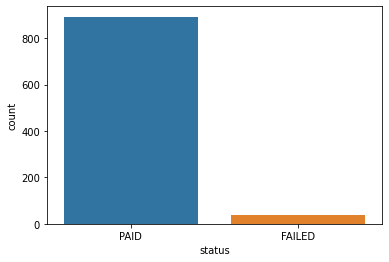

In [332]:
df_classification = df[["PayerId","ReceiverId","NormalizedAmount","amount","amountfinancedByXepelin","NormalizedAmountFinancedByXepelin","status"]]
df_classification_prediction_set = df_classification.loc[df_classification["status"].isin(["PROCESSING"])][["PayerId","ReceiverId","NormalizedAmount","NormalizedAmountFinancedByXepelin","amount","amountfinancedByXepelin"]]
df_classification_training_set = df_classification.loc[~df_classification["status"].isin(["PROCESSING"])][["PayerId","ReceiverId","NormalizedAmount","NormalizedAmountFinancedByXepelin","status"]]
sns.countplot(df_classification_training_set["status"])

c:\Python39\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


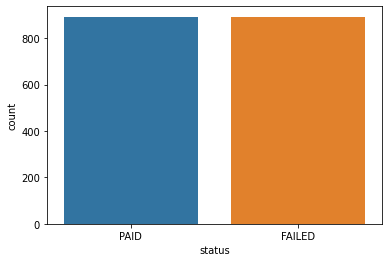

In [269]:
# Target feature is really imbalanced. For that reason it's necessary to consider to oversampling the sample. Undersample it's not a good practice when data is extremly imbalanced
# due to important information may be lost

# Althouhg SMOTE is a practice that only works for continues features SMOTE-NC have little variation to work with continues and nominal data

y = df_classification_training_set["status"]
X = df_classification_training_set.drop(["status"],axis=1)

smotenc = SMOTENC(categorical_features=[0,1],random_state=42)
X_nc_smote, y_nc_smote = smotenc.fit_resample(X, y)
sns.countplot(y_nc_smote)

X_train, X_test, y_train, y_test = train_test_split(X_nc_smote,y_nc_smote, random_state = 42)

In [479]:
X_nc_smote[["NormalizedAmount"]].corrwith(y_nc_smote.apply(lambda x: 1 if x=="PAID" else(0 if x=="PROCESSING" else -1)), method="spearman")

NormalizedAmount   -0.106321
dtype: float64

#### Base Estimator



In [270]:
rf_clf = RandomForestClassifier(random_state=42)
lgbm_clf = LGBMClassifier(random_state=42)
lr_clf = LogisticRegression(random_state=42)

model_rf_clf = rf_clf.fit(X_train, y_train)
model_lgbm_clf = lgbm_clf.fit(X_train, y_train)
model_lr_clf = lr_clf.fit(X_train, y_train)

prediction_rf_clf = model_rf_clf.predict(X_test)
prediction_lgbm_clf = model_lgbm_clf.predict(X_test)
prediction_lr_clf = model_lr_clf.predict(X_test)

In [271]:
rf_clf_modeled = pd.DataFrame(classification_report(y_test, prediction_rf_clf, output_dict=True)).transpose()
lgbm_clf_modeled = pd.DataFrame(classification_report(y_test, prediction_lgbm_clf, output_dict=True)).transpose()
lr_clf_modeled = pd.DataFrame(classification_report(y_test, prediction_lr_clf, output_dict=True)).transpose()

precision_metric = pd.concat(
  [
    rf_clf_modeled.rename(columns={"precision":"RF precision"})["RF precision"],
    lgbm_clf_modeled.rename(columns={"precision":"LGBM precision"})["LGBM precision"],
    lr_clf_modeled.rename(columns={"precision":"LR precision"})["LR precision"]
  ],
  axis=1
)

recall_metric = pd.concat(
  [
    rf_clf_modeled.rename(columns={"recall":"RF recall"})["RF recall"],
    lgbm_clf_modeled.rename(columns={"recall":"LGBM recall"})["LGBM recall"],
    lr_clf_modeled.rename(columns={"recall":"LR recall"})["LR recall"]
  ],
  axis=1
)

In [272]:
precision_metric

,RF precision,LGBM precision,LR precision
FAILED,0.885246,0.932203,0.600985
PAID,0.965347,0.985714,0.584362
accuracy,0.921525,0.957399,0.591928
macro avg,0.925296,0.958959,0.592674
weighted avg,0.925296,0.958959,0.592674


In [267]:
recall_metric

,RF recall,LGBM recall,LR recall
FAILED,0.959641,0.991031,0.654709
PAID,0.887892,0.928251,0.560538
accuracy,0.923767,0.959641,0.607623
macro avg,0.923767,0.959641,0.607623
weighted avg,0.923767,0.959641,0.607623


In [389]:
pd.DataFrame(confusion_matrix(y_test, prediction_lgbm_clf, labels=["FAILED","PAID"]))

,0,1
0,220,3
1,16,207


In [311]:
random_search = {
  'boosting_type': ['gbdt', 'dart'],
  'num_leaves': [23,25,27,29,31,33,35],
  'learning_rate': [0.05, 0.1],
  'n_estimators': [100, 120, 140, 160, 180, 200],
  'reg_alpha':[0., 0.001, 0.005, 0.01, 0.05, 0.1],
  'reg_lambda':[0., 0.001, 0.005, 0.01, 0.05, 0.1]
}

model_GridSearch = GridSearchCV(lgbm_clf, random_search, verbose=1, cv=4, n_jobs=-1)
model_RandomizedSearch = RandomizedSearchCV(lgbm_clf, random_search, verbose=1, cv=4, n_jobs=-1, random_state=42)

In [312]:
model_GridSearch.fit(X_train, y_train)
model_RandomizedSearch.fit(X_train, y_train)

Fitting 4 folds for each of 6048 candidates, totalling 24192 fits
Fitting 4 folds for each of 10 candidates, totalling 40 fits


RandomizedSearchCV(cv=4, estimator=LGBMClassifier(random_state=42), n_jobs=-1,
                   param_distributions={'boosting_type': ['gbdt', 'dart'],
                                        'learning_rate': [0.05, 0.1],
                                        'n_estimators': [100, 120, 140, 160,
                                                         180, 200],
                                        'num_leaves': [23, 25, 27, 29, 31, 33,
                                                       35],
                                        'reg_alpha': [0.0, 0.001, 0.005, 0.01,
                                                      0.05, 0.1],
                                        'reg_lambda': [0.0, 0.001, 0.005, 0.01,
                                                       0.05, 0.1]},
                   random_state=42, verbose=1)

In [313]:
GridSearch_prediction = model_GridSearch.predict(X_test)
RandomizedSearch_prediction = model_RandomizedSearch.predict(X_test)

GridSearch_report = pd.DataFrame(classification_report(y_test, GridSearch_prediction, output_dict=True)).transpose()
RandomizedSearch_report = pd.DataFrame(classification_report(y_test, RandomizedSearch_prediction, output_dict=True)).transpose()

precision_metric = pd.concat(
  [
    GridSearch_report.rename(columns={"precision":"GridSearch precision"})["GridSearch precision"],
    RandomizedSearch_report.rename(columns={"precision":"RandomizedSearch precision"})["RandomizedSearch precision"],
  ],
  axis=1
)

recall_metric = pd.concat(
  [
    GridSearch_report.rename(columns={"recall":"GridSearch recall"})["GridSearch recall"],
    RandomizedSearch_report.rename(columns={"recall":"RandomizedSearch recall"})["RandomizedSearch recall"],
  ],
  axis=1
)

In [314]:
precision_metric

,GridSearch precision,RandomizedSearch precision
FAILED,0.936170,0.915966
PAID,0.985782,0.975962
accuracy,0.959641,0.943946
macro avg,0.960976,0.945964
weighted avg,0.960976,0.945964


In [315]:
recall_metric

,GridSearch recall,RandomizedSearch recall
FAILED,0.986547,0.977578
PAID,0.932735,0.910314
accuracy,0.959641,0.943946
macro avg,0.959641,0.943946
weighted avg,0.959641,0.943946


In [319]:
pd.DataFrame(confusion_matrix(y_test, GridSearch_prediction))

,0,1
0,220,3
1,15,208


In [342]:
df_classification_prediction_set_original_data = df_classification_prediction_set[["PayerId","ReceiverId","amount","amountfinancedByXepelin"]]
df_classification_prediction_set_to_predict = df_classification_prediction_set[["PayerId","ReceiverId","NormalizedAmount","NormalizedAmountFinancedByXepelin"]]
prediction_GridSearch = model_GridSearch.predict(df_classification_prediction_set_to_predict)

In [362]:
df_result = pd.merge(df_classification_prediction_set_original_data, df_classification_prediction_set_to_predict, left_index=True, right_index=True, how="inner")
df_result["status"] = prediction_GridSearch

c:\Python39\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='status', ylabel='count'>

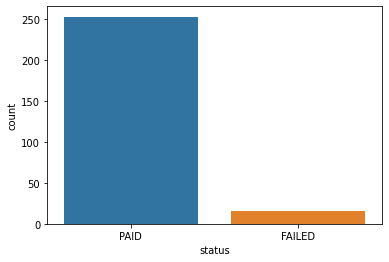

In [396]:
sns.countplot(df_result["status"])

In [434]:
df_result["paidAt_monthly"] = "2022-06"
df_result["paidAt_monthly"] = pd.to_datetime(df_result["paidAt_monthly"], format="%Y-%m")
df_result["paidAt_monthly"] = df_result["paidAt_monthly"].apply(lambda x: dt.datetime.strftime(x, "%Y-%m"))

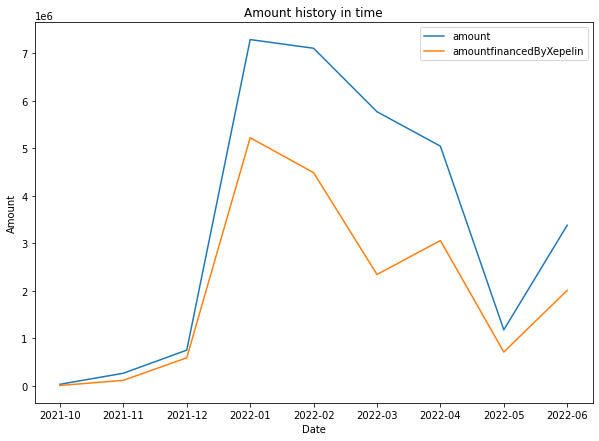

In [478]:
monthly_true = pd.DataFrame(df.groupby(["paidAt_monthly"])["amount"].sum())
monthly_prediction = pd.DataFrame(df_result.groupby(["paidAt_monthly"])["amount"].sum())
monthly_true_financed = pd.DataFrame(df.groupby(["paidAt_monthly"])["amountfinancedByXepelin"].sum())
monthly_prediction_financed = pd.DataFrame(df_result.groupby(["paidAt_monthly"])["amountfinancedByXepelin"].sum())

plt.figure(figsize=(10,7))
plt.plot(pd.concat([monthly_true["amount"],monthly_prediction["amount"]], axis=0))
plt.plot(pd.concat([monthly_true_financed["amountfinancedByXepelin"],monthly_prediction_financed["amountfinancedByXepelin"]], axis=0))
plt.legend(["amount","amountfinancedByXepelin"])
plt.xlabel("Date")
plt.ylabel("Amount")
plt.title("Amount history in time")
plt.show()

